In [1]:
# define a pytensor Op for our likelihood function
from pl_temp_fit import PLPYMCModel,fit_experimental_PLT
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 

Running on PyMC v5.10.3
Running on PyMC v5.10.3


In [2]:
csv_files

NameError: name 'csv_files' is not defined

In [ ]:
print(csv_files[12])
print(csv_files[18])
print(csv_files[7])

experiemental_data/L8BO-noanneal.csv
experiemental_data/ITIC.csv
experiemental_data/ITIC_DIO.csv


Running on PyMC v5.10.3
experiemental_data/ITIC.csv


/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/fit_experimental_PLT.py:111: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


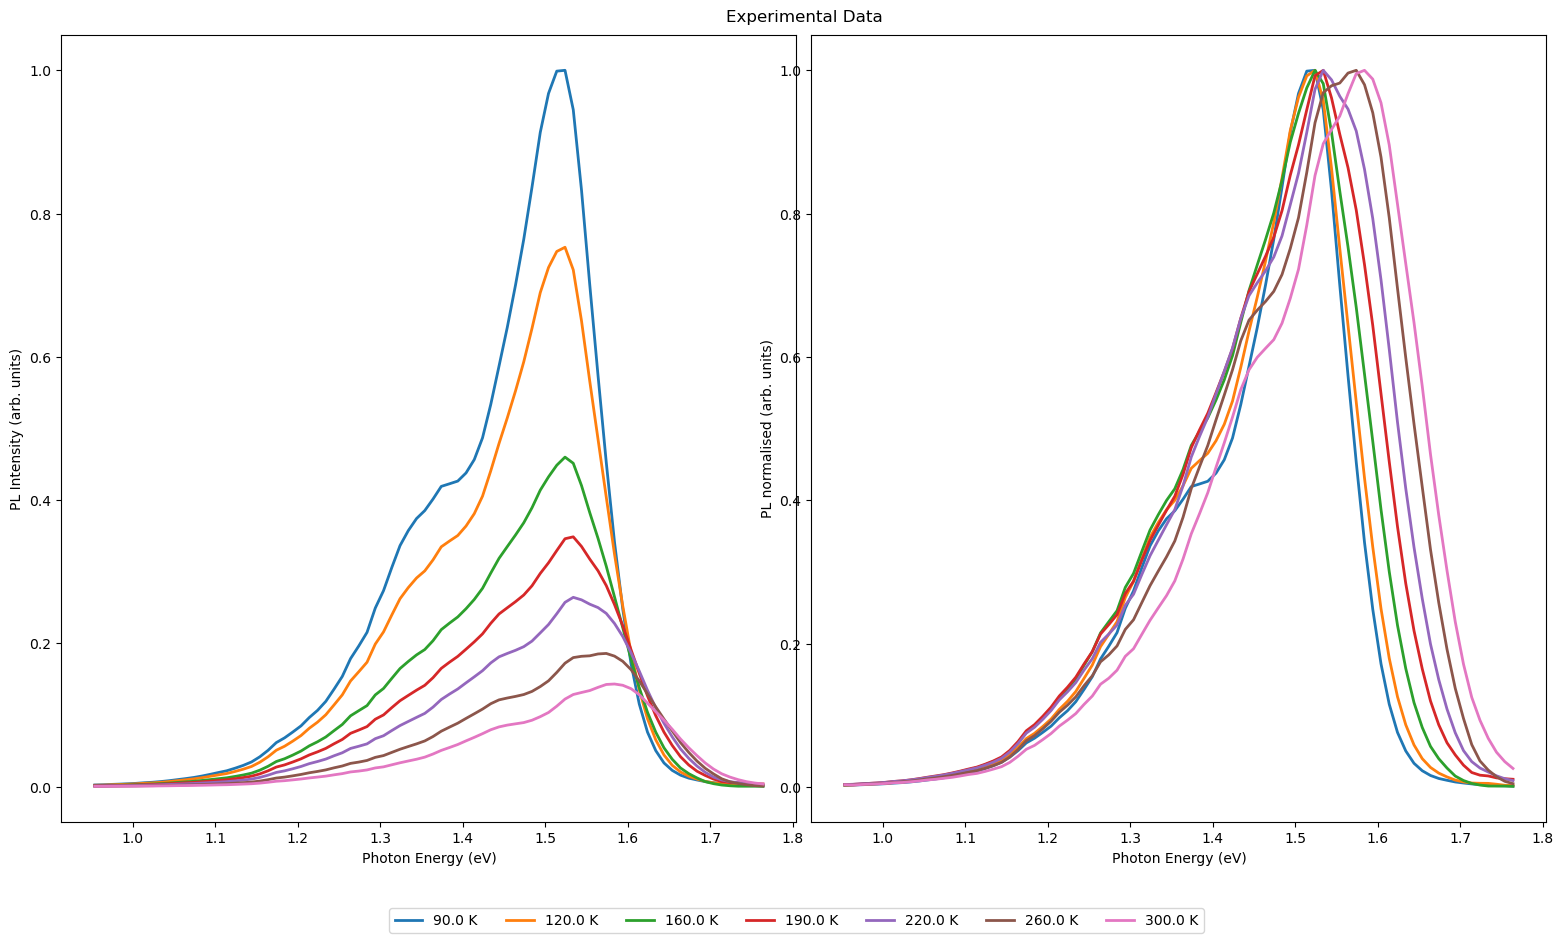

In [27]:
import importlib
importlib.reload(fit_experimental_PLT)
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[18]
print(csv_name)
Exp_data, temperature_list, hws = fit_experimental_PLT.read_data(csv_name)
fit_experimental_PLT.plot_data(Exp_data, temperature_list, hws,title="Experimental Data")


In [28]:
#initialise parameters for the model
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 5, 0.005, 10, 0.005, 0.05
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
X = {'temperature_list':temperature_list, 'hws':hws}
date=datetime.datetime.now().strftime("%Y_%m_%d")
# generate the data
save_folder = (
    f"fit_experimental/{date}/{csv_name.split('/')[-1]}/num_samples="
    + str(num_samples)
    + " num_tune=" + str(num_tune)
    + " sigma=" + str(sigma)
    + " temperature_list=" + str(len(temperature_list))
    + " number_free_parameters=" + str(number_free_parameters)
    + " Temp_std_err="+str(Temp_std_err)
    + " hws_std_err="+str(hws_std_err)
    + " relative_intensity_std_error="+str(relative_intensity_std_error)
)
os.makedirs(save_folder, exist_ok=True)

In [29]:
hws

array([0.95384615, 0.96384615, 0.97384615, 0.98384615, 0.99384615,
       1.00384615, 1.01384615, 1.02384615, 1.03384615, 1.04384615,
       1.05384615, 1.06384615, 1.07384615, 1.08384615, 1.09384615,
       1.10384615, 1.11384615, 1.12384615, 1.13384615, 1.14384615,
       1.15384615, 1.16384615, 1.17384615, 1.18384615, 1.19384615,
       1.20384615, 1.21384615, 1.22384615, 1.23384615, 1.24384615,
       1.25384615, 1.26384615, 1.27384615, 1.28384615, 1.29384615,
       1.30384615, 1.31384615, 1.32384615, 1.33384615, 1.34384615,
       1.35384615, 1.36384615, 1.37384615, 1.38384615, 1.39384615,
       1.40384615, 1.41384615, 1.42384615, 1.43384615, 1.44384615,
       1.45384615, 1.46384615, 1.47384615, 1.48384615, 1.49384615,
       1.50384615, 1.51384615, 1.52384615, 1.53384615, 1.54384615,
       1.55384615, 1.56384615, 1.57384615, 1.58384615, 1.59384615,
       1.60384615, 1.61384615, 1.62384615, 1.63384615, 1.64384615,
       1.65384615, 1.66384615, 1.67384615, 1.68384615, 1.69384

Running on PyMC v5.10.3


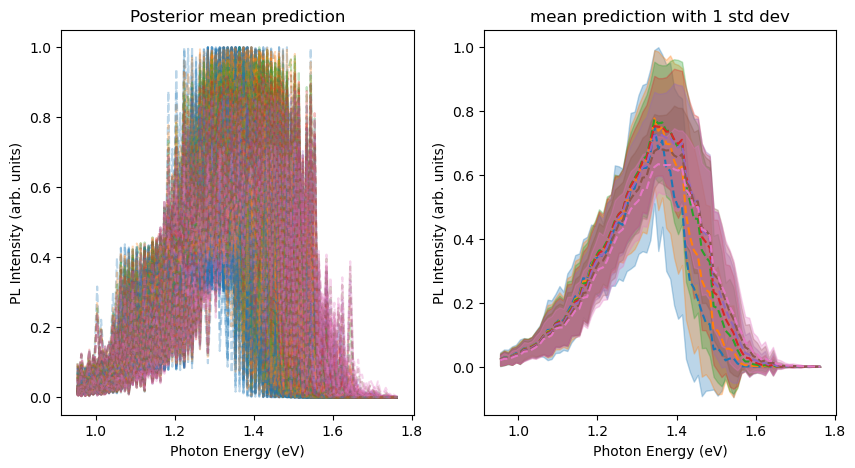

In [30]:
from pl_temp_fit import test_FIT_NEW
import importlib
importlib.reload(fit_experimental_PLT)
importlib.reload(PLPYMCModel)
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 5, 0.001, 0.1, 0.05, 0.00
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
truemodel_pl, true_parameters = fit_experimental_PLT.generate_data(temperature_list, hws, **model_config)
true_model_pl_list,variance,arg_max_variance = fit_experimental_PLT.plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=True)

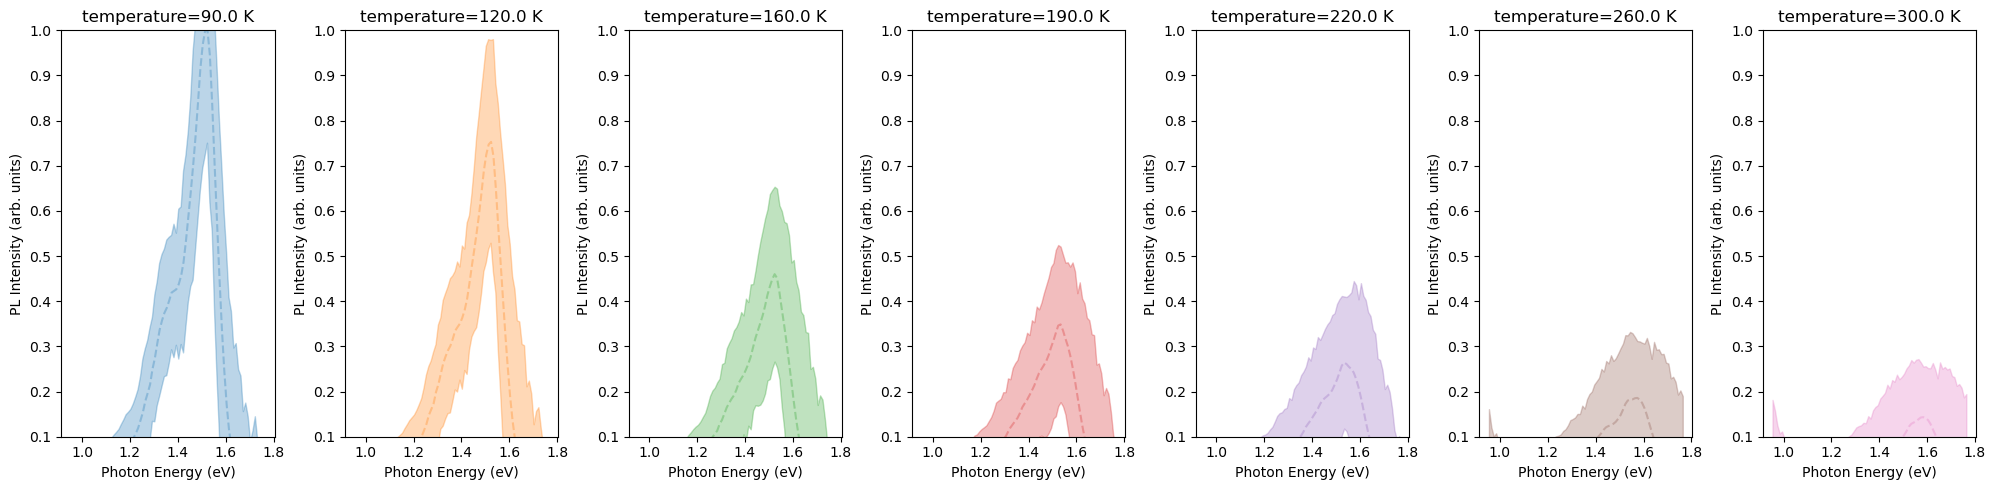

In [31]:
# add noise to the data
variance_data = variance.copy()
argmax_data = np.argmax(Exp_data, axis=0)
for i in range(len(temperature_list)):
    variance_data[:, i] = np.roll(variance_data[:, i], argmax_data[i]-arg_max_variance[i])
variance_data = variance_data+0.005
fit_experimental_PLT.plot_data_with_variance(Exp_data, temperature_list, hws, variance_data, save_folder)


In [ ]:
## initialise the model and run the fit
importlib.reload(PLPYMCModel)
model = PLPYMCModel.PLPYMCModel()
for key, value in model_config.items():
    model.model_config[key] = value
print(model.model_config)      
model.sampler_config['step'] = "Metropolis(tune_interval =50)"#"[pm.DEMetropolis([self.E,self.LI,self.sigma_E]),pm.DEMetropolis([self.L0,self.H0])]"  
print(model.sampler_config)
model.fit(X, Exp_data,sigma = variance_data, draws=num_samples, tune=num_tune, chains=4, step=model.sampler_config['step'] , return_inferencedata=True)
print(az.summary(model.idata))
model.plot_trace(true_parameters=None, save_folder=save_folder, savefig=True)
# save the data
model.idata.to_netcdf(save_folder + "/idata.nc")
model.plot_posterior_prediction(Exp_data,  temperature_list, hws, save_folder=save_folder, savefig=True)
fname = "/model.nc"
model.save(save_folder+fname)

{'number_free_parameters': 5, 'E': {'min': 1.0, 'max': 2.0}, 'sigma_E': {'min': 0.001, 'max': 0.03}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.15, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 2, 'hws_std_err': 0.0, 'relative_intensity_std_error': 0.05, 'sigma': 0.001}
{'draws': 10, 'tune': 5, 'chains': 3, 'step': 'Metropolis(tune_interval =50)', 'return_inferencedata': True}
{'draws': 1000, 'tune': 1000, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E]
>Metropolis: [sigma_E]
>Metropolis: [LI]
>Metropolis: [L0]
>Metropolis: [H0]


/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Acceptance rate: Acceptance rate:[0.04]  -> Tuned scale:[0.04]  [0.5]-> Tuned scale:
 [0.5]
Acceptance rate:Acceptance rate:  [0.14] [0.14]-> Tuned scale:  -> Tuned scale:[0.9] 
[0.9]
Acceptance rate:Acceptance rate:  [0.64][0.54]  -> Tuned scale:-> Tuned scale:  [1.1][1.1]

Acceptance rate:Acceptance rate:  [0.16] [0.24]-> Tuned scale:  -> Tuned scale:[0.9] 
[1.]
Acceptance rate:Acceptance rate:  [0.06] [0.26] -> Tuned scale:-> Tuned scale:  [0.9][1.]

Acceptance rate:Acceptance rate:  [0.04][0.02]  -> Tuned scale:-> Tuned scale:  [0.5][0.5]

Acceptance rate:Acceptance rate:  [0.56][0.14]  -> Tuned scale:-> Tuned scale:  [0.9][1.1]

Acceptance rate:Acceptance rate:  [0.3][0.54]  -> Tuned scale:-> Tuned scale:  [1.][1.1]

Acceptance rate:Acceptance rate:  [0.14] [0.04]-> Tuned scale:  -> Tuned scale:[0.9] 
[0.5]
Acceptance rate: Acceptance rate:[0.16]  [0.02]-> Tuned scale:  [0.9]-> Tuned scale:
 [0.5]
Acceptance rate:Acceptance rate:  [0.04][0.]  -> Tuned scale:-> Tuned scale:  [0.25]

ValueError: Not enough samples to build a trace.

Running on PyMC v5.10.3
Running test number 1
{'num_samples': 4500, 'num_tune': 2000, 'sigma': 0.01, 'Temp_std_err': 2, 'hws_std_err': 0.05, 'relative_intensity_std_error': 0.1}
17
size of hw is (82,)
size of temperature_list is (7,)


{'number_free_parameters': 5, 'E': {'min': 1.0, 'max': 2.0}, 'sigma_E': {'min': 0.001, 'max': 0.03}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.15, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 2, 'hws_std_err': 0.05, 'relative_intensity_std_error': 0.1, 'sigma': 0.01}
{'draws': 10, 'tune': 5, 'chains': 3, 'step': 'Metropolis(tune_interval =400)', 'return_inferencedata': True}
{'draws': 4500, 'tune': 2000, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E]
>Metropolis: [sigma_E]
>Metropolis: [LI]
>Metropolis: [L0]
>Metropolis: [H0]


/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/Sampler.py:232: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


ValueError: Not enough samples to build a trace.

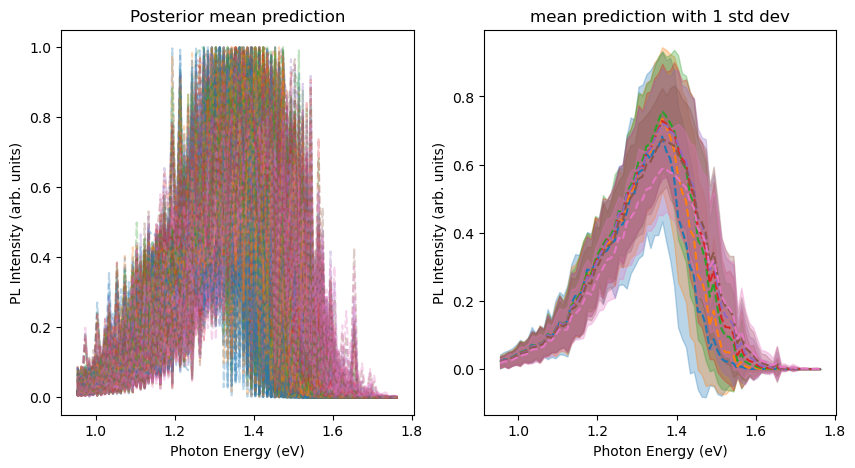

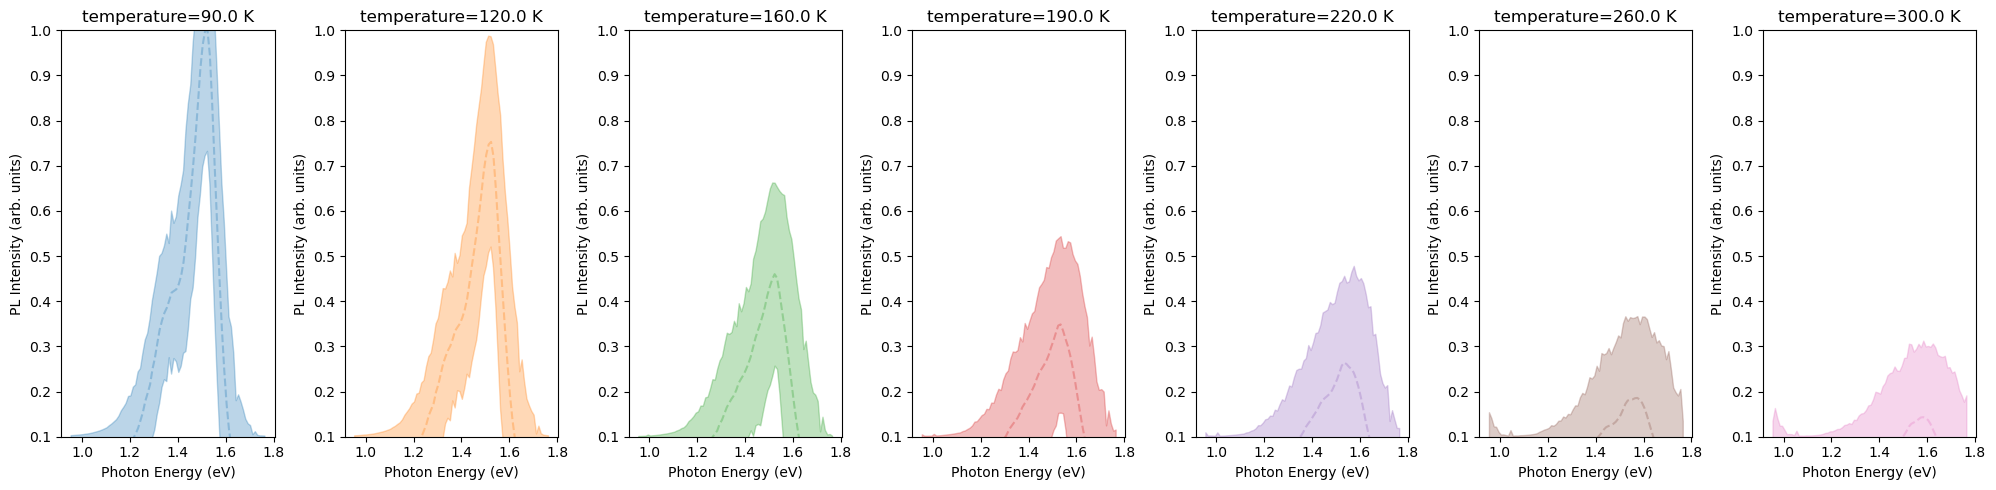

In [32]:
%run src/pl_temp_fit/fit_experimental_PLT.py --data_file {csv_name} --test_number 1

In [26]:
# submit to HPC
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=16:mem=4gb:avx=true \n"+\
    f"#PBS -J 1-{17} \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pymc_env     \n"+\
    f"python src/pl_temp_fit/fit_experimental_PLT.py --test_number ${'PBS_ARRAY_INDEX'} --data_file {csv_name} \n"
#print(script) 
with open(f'HPC_bash_script/Runtest_Experiment_ITIC.sh', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  

!qsub  -e ./cache -o ./cache HPC_bash_script/Runtest_Experiment_ITIC.sh

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file


# Analyse fit results


Running on PyMC v5.10.3
experiemental_data/L8BO-noanneal.csv


/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/fit_experimental_PLT.py:111: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


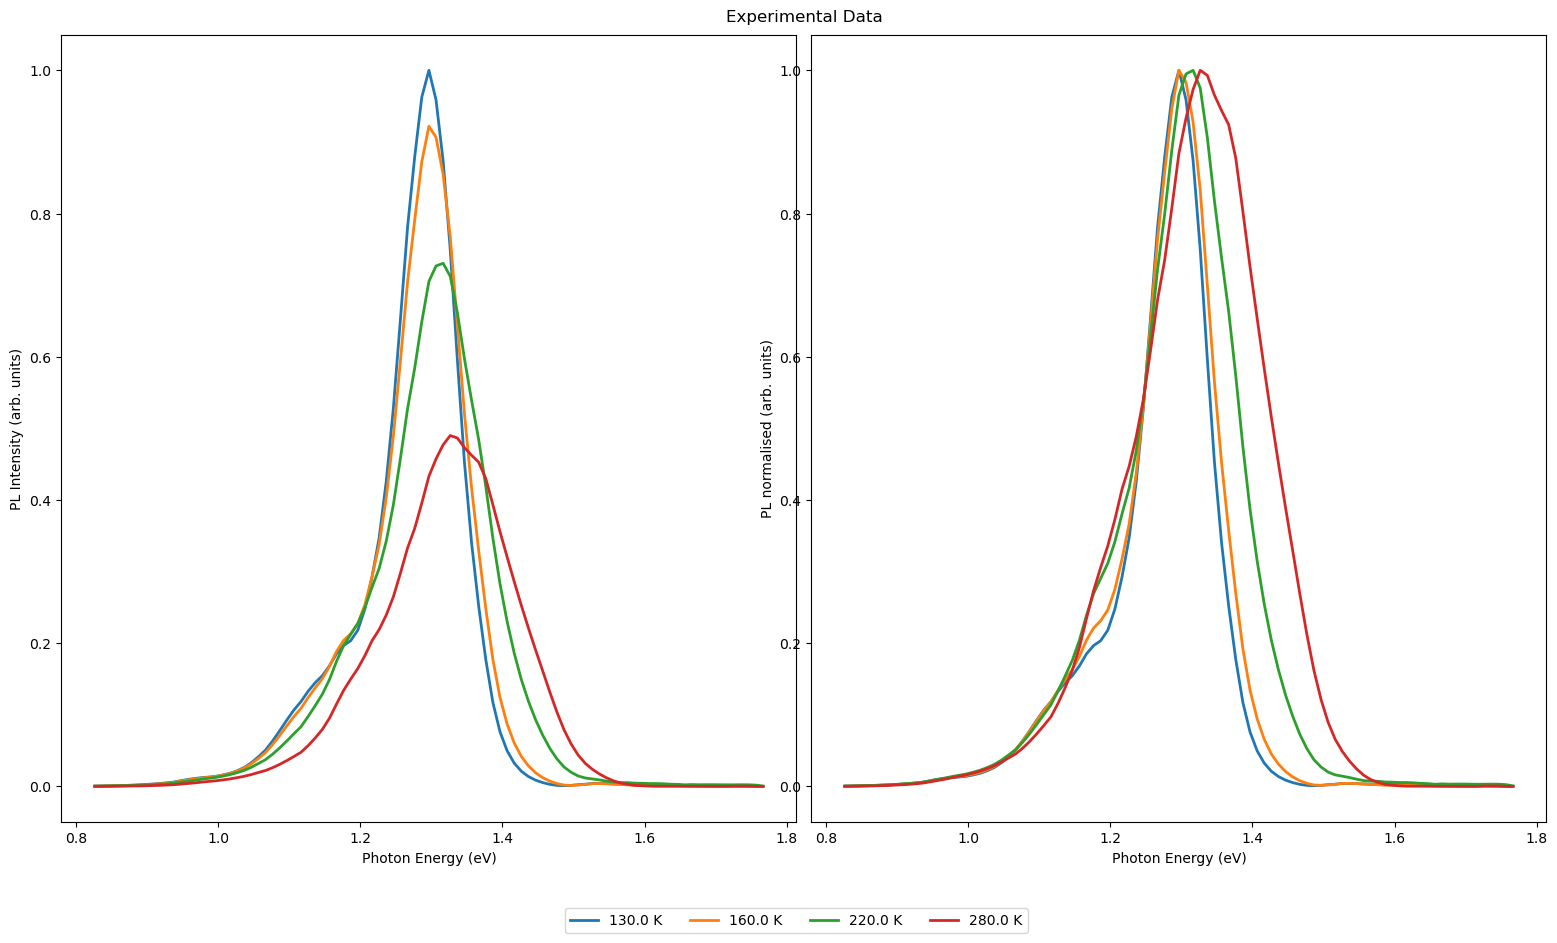

In [17]:
# analyse results
import importlib
importlib.reload(fit_experimental_PLT)
import glob
csv_files = glob.glob('experiemental_data/*.csv')
csv_name=csv_files[12]
print(csv_name)
Exp_data, temperature_list, hws = fit_experimental_PLT.read_data(csv_name)
fit_experimental_PLT.plot_data(Exp_data, temperature_list, hws,title="Experimental Data")

import arviz
model = PLPYMCModel.PLPYMCModel()
folder = glob.glob(f"fit_experimental/2024_01_14/{csv_name.split('/')[-1]}/*")
exp_data_dict_exp = {}
model_dict_exp = {}
for f in folder:
    name = f.split('/')[-1]
    if 'idata.nc' in os.listdir(f):
        exp_results = arviz.from_netcdf(f'{f}/idata.nc')
        exp_data_dict_exp[name] = exp_results
    if 'model.nc' in os.listdir(f):
        model_2 = model.load(f'{f}/model.nc')
        model_dict_exp[name] = model_2

In [18]:
# put results into a dataframe
list_params = []

for key,model in model_dict_exp.items():
    params_dict = {}
    for x in key.split(' '):
        params_dict[x.split('=')[0]]=float(x.split('=')[1])
    df_summary = arviz.summary(model.idata)
    print(name, df_summary['r_hat'].values.max())
    params_dict['r_hat'] = df_summary['r_hat'].values.max()
    params_dict['mean'] = df_summary['mean'].values
    params_dict['key'] = key
    list_params.append(params_dict)

import pandas as pd
df = pd.DataFrame.from_records(list_params)
df

num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01 3.0
num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01 1.8
num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01 1.07
num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01 1.23
num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01 2.41
num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01 2.21
num_samples=10000 num_tune=1000 sigma=0.01

,num_samples,num_tune,sigma,temperature_list,number_free_parameters,Temp_std_err,hws_std_err,relative_intensity_std_error,r_hat,mean,key
0,10000.0,1000.0,0.002,4.0,5.0,0.1,0.005,0.05,3.00,"[1.406, 0.02, 0.05, 0.077, 0.163]",num_samples=10000 num_tune=1000 sigma=0.002 te...
1,10000.0,1000.0,0.002,4.0,5.0,0.1,0.005,0.01,1.80,"[1.406, 0.016, 0.055, 0.088, 0.169]",num_samples=10000 num_tune=1000 sigma=0.002 te...
2,10000.0,1000.0,0.010,4.0,5.0,2.0,0.001,0.05,1.07,"[1.401, 0.018, 0.055, 0.079, 0.168]",num_samples=10000 num_tune=1000 sigma=0.01 tem...
3,10000.0,1000.0,0.010,4.0,5.0,0.1,0.005,0.01,1.23,"[1.403, 0.018, 0.056, 0.082, 0.168]",num_samples=10000 num_tune=1000 sigma=0.01 tem...
4,10000.0,1000.0,0.002,4.0,5.0,2.0,0.001,0.05,2.41,"[1.402, 0.019, 0.05, 0.078, 0.168]",num_samples=10000 num_tune=1000 sigma=0.002 te...
5,10000.0,1000.0,0.002,4.0,5.0,10.0,0.001,0.01,2.21,"[1.409, 0.016, 0.054, 0.089, 0.169]",num_samples=10000 num_tune=1000 sigma=0.002 te...
6,1000.0,1000.0,0.001,4.0,5.0,2.0,0.000,0.05,4.87,"[1.395, 0.017, 0.05, 0.073, 0.154]",num_samples=1000 num_tune=1000 sigma=0.001 tem...
7,10000.0,1000.0,0.010,4.0,5.0,10.0,0.001,0.01,1.28,"[1.403, 0.018, 0.056, 0.082, 0.168]",num_samples=10000 num_tune=1000 sigma=0.01 tem...
8,10000.0,1000.0,0.010,4.0,5.0,10.0,0.001,0.05,1.81,"[1.401, 0.019, 0.053, 0.076, 0.163]",num_samples=10000 num_tune=1000 sigma=0.01 tem...
9,10000.0,1000.0,0.002,4.0,5.0,2.0,0.001,0.01,2.02,"[1.403, 0.018, 0.055, 0.081, 0.168]",num_samples=10000 num_tune=1000 sigma=0.002 te...


num_samples=10000 num_tune=1000 sigma=0.01 temperature_list=4 number_free_parameters=5 Temp_std_err=10 hws_std_err=0.005 relative_intensity_std_error=0.01
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
E        1.404  0.001   1.403    1.406        0.0      0.0      57.0   
sigma_E  0.018  0.000   0.017    0.018        0.0      0.0      16.0   
LI       0.056  0.000   0.055    0.056        0.0      0.0      37.0   
L0       0.083  0.001   0.081    0.085        0.0      0.0      28.0   
H0       0.168  0.000   0.168    0.169        0.0      0.0    1834.0   

         ess_tail  r_hat  
E            56.0   1.04  
sigma_E      38.0   1.16  
LI           84.0   1.08  
L0           55.0   1.11  
H0         2062.0   1.01  
------------------
------------------


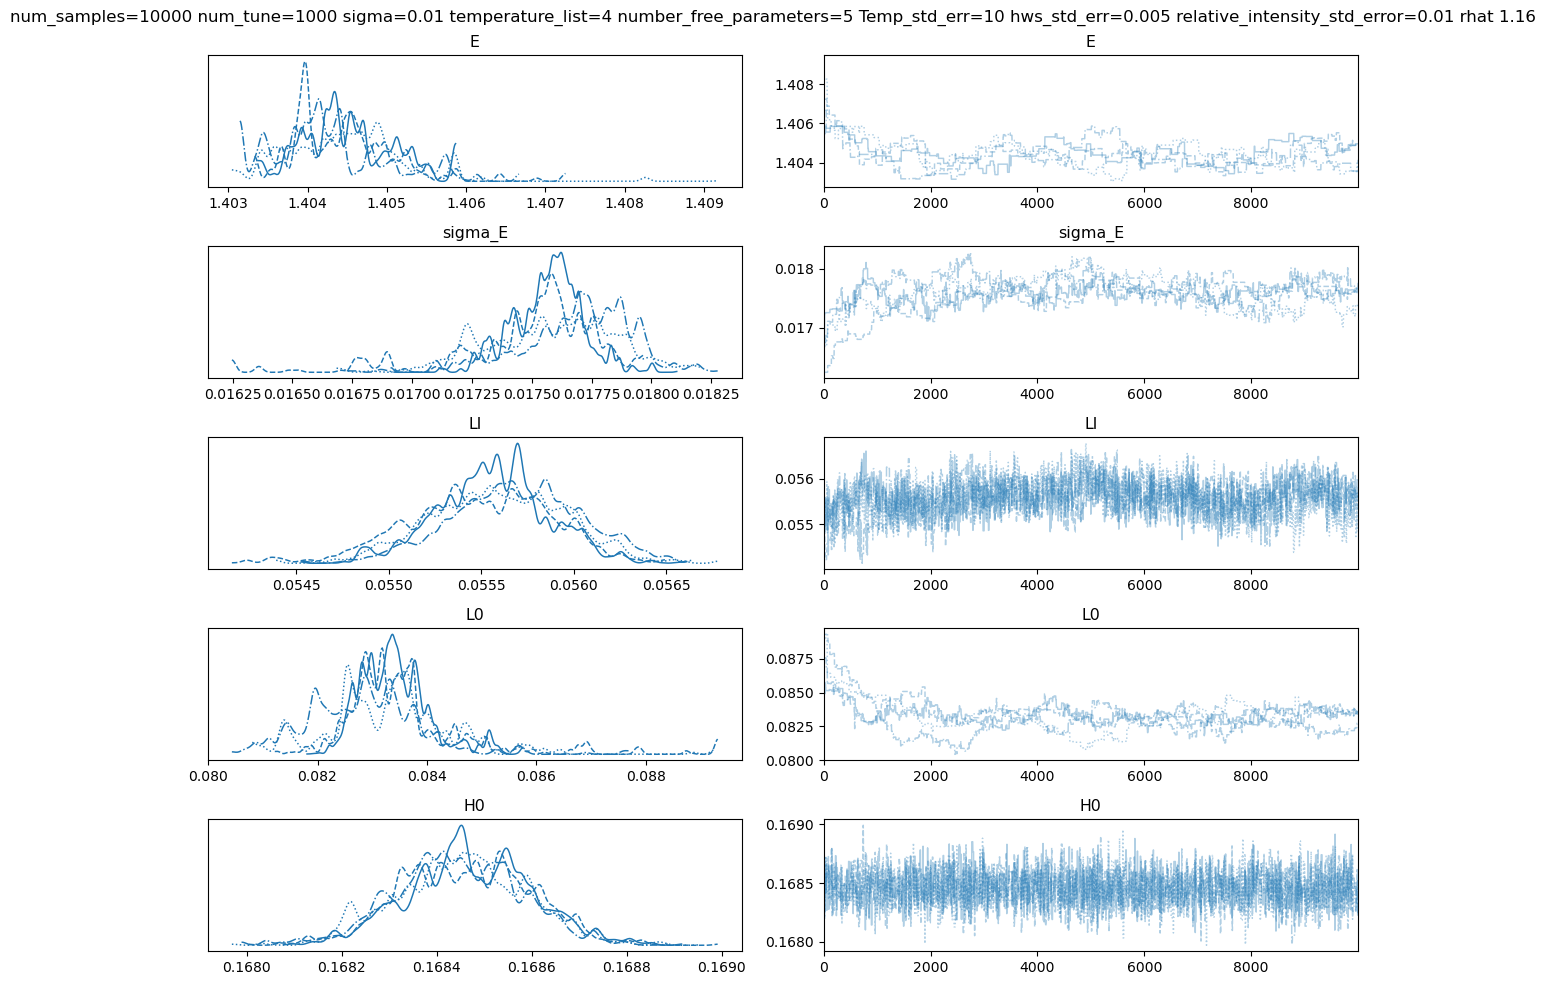

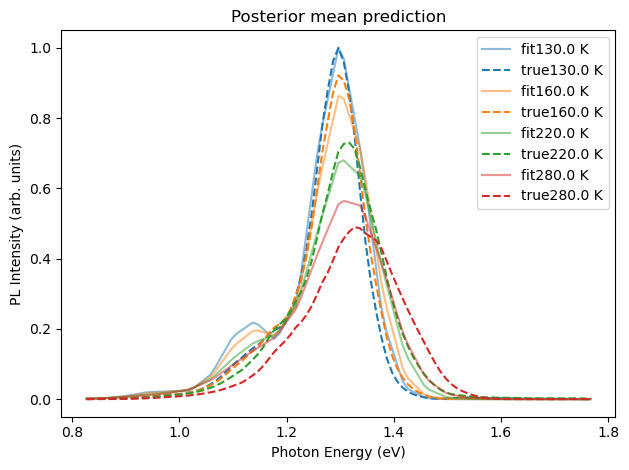

In [19]:
def plot_fit_results(name,Exp_data,  temperature_list, hws, save_folder="", savefig=False):
    print(name)
    model = model_dict_exp[name]
    df_summary = arviz.summary(model.idata)
    print(df_summary)
    print('------------------')
    print('------------------')
    fig = model.plot_trace(None, save_folder="", savefig=False)
    fig.suptitle(name + f" rhat {df_summary['r_hat'].values.max()}")
    fig.show()           

    model.plot_posterior_prediction(Exp_data,  temperature_list, hws, save_folder="", savefig=False)



plot_fit_results(df.loc[24]['key'],Exp_data,  temperature_list, hws, save_folder="", savefig=False)        

        


array([[<Axes: title={'center': 'E'}>, <Axes: title={'center': 'L0'}>,
        <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'LI'}>,
        <Axes: title={'center': 'sigma_E'}>, <Axes: >]], dtype=object)

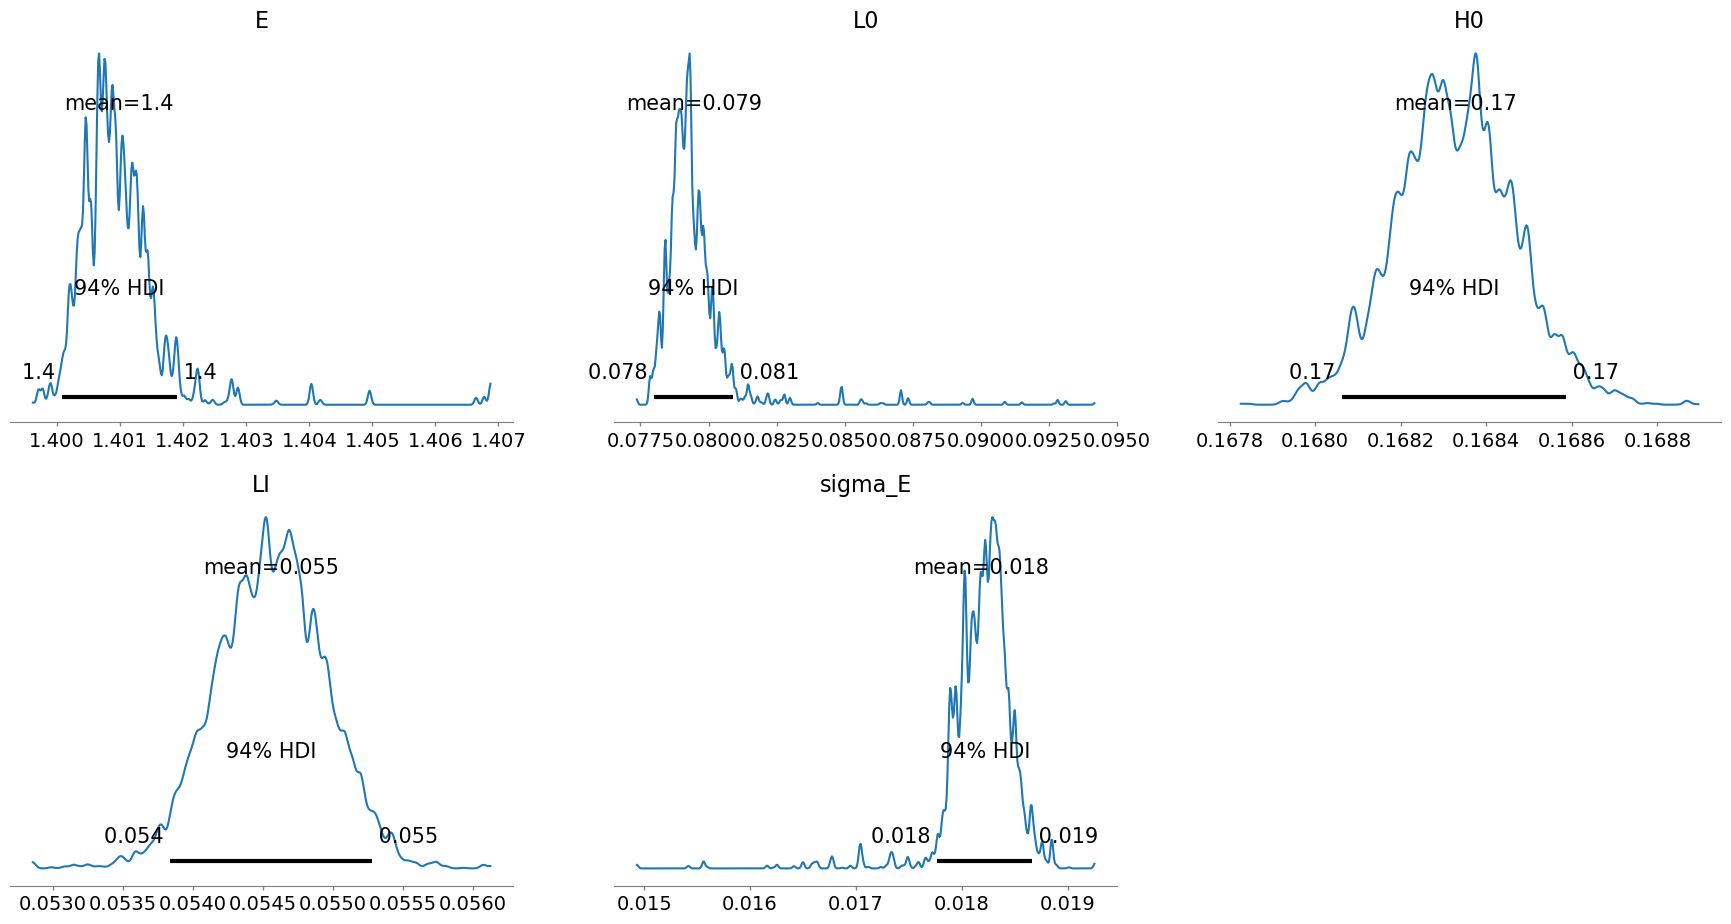

In [22]:
model = model_dict_exp[df.loc[2]['key']]
arviz.plot_posterior(model.idata, var_names=["E", "L0", "H0", "LI", "sigma_E"], kind="kde")